# Investigating SFPD incident reports

### By Eric Sagara

This walkthrough is designed to show you how I approach a new data analysis. It requires a couple of libraries that you may or may not be familiar with. The first is Pandas which is installed by using `pip install pandas`. The second is numpy, which is a Pandas dependency - in other words it should automatically install when you install pandas. Lastly is the charting library Altair and it's dependency Vega. These are installed using `pip install altair vega`.

Let's begin by importing our libraries. In Jupyter Notebook you need to enable Altair's rendering engine by adding `alt.renderers.enable('notebook')` after importing.

In [1]:
import pandas as pd
import numpy as np
import altair as alt


# Enable Altair's rendering engine
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Loading data

There are two methods of loading the data. You can either download the data ahead of time and load the file or just pass the url where the file is located into pandas' `read_csv` method. We are also going to parse one of the date fields into a python `datetime` object on import.

In [5]:
# Use the filepath url if the data is stored on your computer, 
# otherwise use the csv_url to download and load it into pandas
filepath = 'data/sfpd_incidents_2018_to_present_20190228.csv'
csv_url = 'https://data.sfgov.org/api/views/wg3w-h783/rows.csv?accessType=DOWNLOAD'

# Note we use the parse_dates parameter to convert the 
# Incident Date field values to datetime objects
incidents = pd.read_csv(filepath, parse_dates = ['Incident Date'])

## First look at the data

Let's start to get a general idea of what the data looks like. We begin simply by lookiing at the first few rows of the data.

In [6]:
incidents.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point
0,2018/10/22 10:50:00 AM,2018-10-22,10:50,2018,Monday,2018/10/22 11:24:00 AM,72897505073,728975,180801798,182951518.0,...,"Burglary, Other Bldg., Unlawful Entry",Open or Active,VAN NESS AVE \ OAK ST,30705000.0,Northern,Tenderloin,6.0,37.775422,-122.419397,"(37.7754222198843, -122.41939688941916)"
1,2018/08/24 02:50:00 PM,2018-08-24,14:50,2018,Friday,2018/08/24 02:52:00 PM,72925174010,729251,180638466,181362475.0,...,Missing Juvenile,Open or Active,28TH AVE \ VICENTE ST,23250000.0,Taraval,Sunset/Parkside,4.0,37.738900,-122.485074,"(37.738899869536326, -122.48507449528636)"
2,2018/10/14 02:54:00 PM,2018-10-14,14:54,2018,Sunday,2018/10/24 01:10:00 PM,72980906303,729809,180807520,182971760.0,...,"Theft, From Building, $200-$950",Open or Active,PINTO AVE \ ARBALLO DR,23104000.0,Taraval,Lakeshore,7.0,37.720450,-122.483015,"(37.7204499957522, -122.48301534194144)"
3,2018/10/14 02:54:00 PM,2018-10-14,14:54,2018,Sunday,2018/10/24 01:10:00 PM,72980964070,729809,180807520,182971760.0,...,Suspicious Occurrence,Open or Active,PINTO AVE \ ARBALLO DR,23104000.0,Taraval,Lakeshore,7.0,37.720450,-122.483015,"(37.7204499957522, -122.48301534194144)"
4,2018/10/18 04:40:00 PM,2018-10-18,16:40,2018,Thursday,2018/10/26 07:42:00 AM,73011316650,730113,180791014,182911410.0,...,Methamphetamine Offense,Cite or Arrest Adult,BOARDMAN PL \ BRYANT ST,23914000.0,Southern,South of Market,6.0,37.775161,-122.403636,"(37.7751608100771, -122.40363551943442)"


Next let's get a deeper sense of what the individual columns are.

In [7]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176242 entries, 0 to 176241
Data columns (total 26 columns):
Incident Datetime          176242 non-null object
Incident Date              176242 non-null datetime64[ns]
Incident Time              176242 non-null object
Incident Year              176242 non-null int64
Incident Day of Week       176242 non-null object
Report Datetime            176242 non-null object
Row ID                     176242 non-null int64
Incident ID                176242 non-null int64
Incident Number            176242 non-null int64
CAD Number                 135931 non-null float64
Report Type Code           176242 non-null object
Report Type Description    176242 non-null object
Filed Online               37841 non-null object
Incident Code              176242 non-null int64
Incident Category          176225 non-null object
Incident Subcategory       176225 non-null object
Incident Description       176242 non-null object
Resolution                 176242 no

### Looking for unique IDs

There are several columns which appear to possibly be unique IDs for incidents. We should check and make sure they are what we think they are.

In [8]:
id_columns = ['Row ID', 'Incident ID', 'Incident Number', 'CAD Number']

for column in id_columns:
    print(column, incidents[column].duplicated().unique())

Row ID [False]
Incident ID [False  True]
Incident Number [False  True]
CAD Number [False  True]


This shows us that there are duplicate values in every column except `Row ID`. This is important to keep in mind. It means there are multiple incidents or crimes associated with a given report. Why is this important? Well many times we like to conduct sanity checks by comparing total numbers of crimes against other publically available data sources. Other times we want to compare one city's crime rates against anothers. To do so you will need to access another data source such as the FBI's UCR program.

There's a large caveat when working with UCR data. The FBI requires that each report be filed only once under a single crime category. The crime category is based off of the most serious offense and any other crimes associated with a given incident would not appear in the FBI data.

For example, let's say someone was kidnapped and then murdered. In the SFPD data this would appear as two records - one for the kidnapping and another for the murder. However, in the FBI data this would only be counted as a murder, the kidnapping would be ignored for the purposes of data collection.

This means that any numbers generated from SFPD most likely will not match up exactly with FBI figures. This is not necessarily a big deal. You are not looking for exact matches when conducting sanity checks between multiple sources, you just want to make sure your numbers are in the ballpark with other publically available figures.

### Checking to see how complete the data is

Often there is a lag in data collection or early data collection efforts could be spotty. This means we could have days, months or even years with incomplete data. We should check this to make sure we are working with a complete data set. We can do this using the `Incident Date` column.

In [9]:
incidents['Incident Date'].describe()

count                  176242
unique                    423
top       2018-08-01 00:00:00
freq                      543
first     2018-01-01 00:00:00
last      2019-02-27 00:00:00
Name: Incident Date, dtype: object

This tells us data collection began on January 1, 2018 and the data is current through February 26, 2019. However that doesn't give us the entire picture. Rather than examine the data day-by-day, let's start by doing a `groupby` operation using the `Incident Date` and the `Row ID` column that has unique values.

In [10]:
incidents_by_day = incidents[['Incident Date', 'Row ID']].groupby('Incident Date', as_index = False).count()
incidents_by_day.head()

,Incident Date,Row ID
0,2018-01-01,483
1,2018-01-02,399
2,2018-01-03,431
3,2018-01-04,472
4,2018-01-05,466


And let's use Altair to dive in further, but first let's rename the `Row ID` column into something that makes sense.

We start by creating a `Chart` object and passing in our data that we want to chart. Then we specify what type of chart we want - in this case a line chart - and finally what the X and Y axes will be.

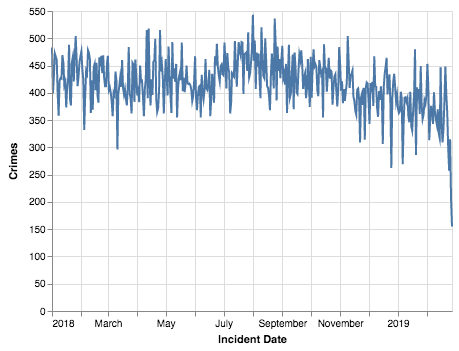

In [12]:
incidents_by_day.rename(columns = {'Row ID' : 'Crimes'}, inplace = True)

alt.Chart(incidents_by_day).mark_line().encode(x = 'Incident Date', y = 'Crimes')

It's hard to see, but it looks like there is a dip in reported crimes near the end of our data collection period. We can get a closer look by creating a "zoomed in" look at the data. We are going to create the same chart as above, but this time filter for only those crimes reported in 2019 using the `dt.year` method to return only the year of the datetime object.

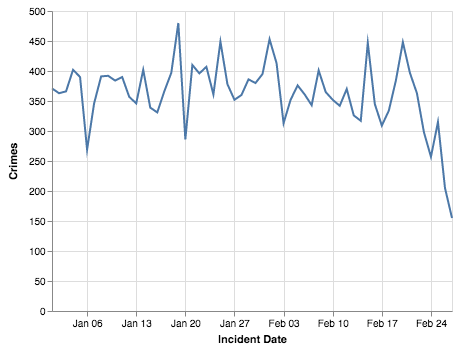

In [13]:
alt.Chart(
    incidents_by_day[incidents_by_day['Incident Date'].dt.year == 2019]
    ).mark_line(
    ).encode(
        x = 'Incident Date', 
        y = 'Crimes'
    )

It's immediately clear that there is a lag in data collection for the last few days in February. We should probably correct for that by excluding at least February. In this case we are going to filter our data so we are only dealing with 2018 crimes.

In [14]:
incidents = incidents[incidents['Incident Date'].dt.year == 2018]

## Now a little bit of cleaning

Let's make some changes to the data so it's a little bit easier to work with. Let's start with converting two other date fields into datetime objects in case we want to work with those fields. The first field is the `Incident Datetime` field. The second is the `Report Datetime` field. We won't work with these fields too much here, but it allows us to do things like check how long it was between when an incident occurred and when a report was filed.

To do this we are going to use Pandas' built-in `to_datetime` function. We need to pass in the column that contains the date information. We also need to specify what format the date is in using the `format` keyword argument. For more information on how to code the formats see this [documentation](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In [15]:
incidents['incident_timestamp'] = pd.to_datetime(incidents['Incident Datetime'], format = '%Y/%m/%d %I:%M:%S %p')
incidents[['Incident Datetime', 'incident_timestamp']].head()

,Incident Datetime,incident_timestamp
0,2018/10/22 10:50:00 AM,2018-10-22 10:50:00
1,2018/08/24 02:50:00 PM,2018-08-24 14:50:00
2,2018/10/14 02:54:00 PM,2018-10-14 14:54:00
3,2018/10/14 02:54:00 PM,2018-10-14 14:54:00
4,2018/10/18 04:40:00 PM,2018-10-18 16:40:00


In [16]:
incidents['report_timestamp'] = pd.to_datetime(incidents['Report Datetime'], format = '%Y/%m/%d %I:%M:%S %p')
incidents[['Report Datetime', 'report_timestamp']].head()

,Report Datetime,report_timestamp
0,2018/10/22 11:24:00 AM,2018-10-22 11:24:00
1,2018/08/24 02:52:00 PM,2018-08-24 14:52:00
2,2018/10/24 01:10:00 PM,2018-10-24 13:10:00
3,2018/10/24 01:10:00 PM,2018-10-24 13:10:00
4,2018/10/26 07:42:00 AM,2018-10-26 07:42:00


There is also a `Resolution` column which indicates the status of the crime at the time the report was created. It's important to note that this data does not appear to reflect the results of any investigation after the initial report was created. However, we can still use this to create a `case_status` column to show the status of the case at the time of the filing. Let's start by seeing what the unique value in the `Resolution` field are.

In [17]:
incidents['Resolution'].unique()

array(['Open or Active', 'Cite or Arrest Adult', 'Unfounded',
       'Exceptional Adult', 'Cite or Arrest Juvenile',
       'Exceptional Juvenile'], dtype=object)

Uhoh. One of the possible values for the `Resolution` column is `Unfounded` which means the responding officer found no crime at the incident. You may find value in this depending on what the goal of your analysis is, but in this case we should probably filter that out of our dataset.

In [18]:
incidents = incidents[incidents['Resolution'] != 'Unfounded']

Ok now that we have done that we can start coding our `case_status` column. We will take advantage of Pandas' `.loc` function to target specific columns and rows in the data set.

The `.loc` function works in this case by passing in what we want to filter rows by along with which column we want to alter. First let's create the column and assign null values to it using numpy's `nan`.

In [19]:
incidents['case_status'] = np.nan
incidents['case_status'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: case_status, dtype: float64

Now let's code in open vs closed cases.

In [20]:
incidents.loc[incidents['Resolution'] == 'Open or Active', 'case_status'] = 'Open'
incidents['case_status'].head()

0    Open
1    Open
2    Open
3    Open
4     NaN
Name: case_status, dtype: object

We're halfway there - we still have `NaN` values for cases that were closed. Rather than use the `.loc` method we can take a simpler approach by replacing `NaN` values with `closed`

In [21]:
incidents['case_status'].fillna('Closed', inplace = True)
incidents['case_status'].head()

0      Open
1      Open
2      Open
3      Open
4    Closed
Name: case_status, dtype: object

## Digging in with some analysis

Let's start by finding out what crimes are reported in this data and which ones are the most common.

In [22]:
incidents['Incident Category'].unique()

array(['Burglary', 'Missing Person', 'Larceny Theft', 'Suspicious Occ',
       'Drug Offense', 'Traffic Violation Arrest', 'Non-Criminal',
       'Other Miscellaneous', 'Robbery', 'Assault', 'Malicious Mischief',
       'Miscellaneous Investigation', 'Lost Property',
       'Vehicle Impounded', 'Other', 'Motor Vehicle Theft', 'Fraud',
       'Offences Against The Family And Children', 'Weapons Carrying Etc',
       'Drug Violation', 'Warrant', 'Prostitution', 'Rape',
       'Embezzlement', 'Civil Sidewalks', 'Other Offenses',
       'Case Closure', 'Recovered Vehicle', 'Disorderly Conduct',
       'Forgery And Counterfeiting', 'Weapons Offense', 'Stolen Property',
       'Arson', 'Family Offense', 'Sex Offense', 'Juvenile Offenses',
       'Courtesy Report', 'Vandalism', 'Traffic Collision', 'Liquor Laws',
       'Fire Report', 'Vehicle Misplaced', 'Weapons Offence', 'Homicide',
       'Suicide', 'Suspicious', 'Motor Vehicle Theft?',
       'Human Trafficking (A), Commercial Sex Acts',

Oops. There are `NaN` values in this column as well. Let's get an idea of how often that occurs.

In [23]:
incidents.loc[incidents['Incident Category'].isna() == True, 'Row ID'].count()

15

Ok good, there are only 15 crimes where this is true. We could filter this out but by default Pandas should exclude these from most of the functions we use to analyze the data. Let's get an idea of the ten most common crimes.

In [24]:
crime_count = incidents[['Incident Category', 'Row ID']].groupby('Incident Category', as_index = False).count()
crime_count.rename(columns = {'Row ID' : 'Crimes'}, inplace = True)

crime_count.sort_values('Crimes', ascending = False).head(10)

,Incident Category,Crimes
19,Larceny Theft,48699
30,Other Miscellaneous,11951
27,Non-Criminal,9477
1,Assault,9092
22,Malicious Mischief,8855
2,Burglary,7109
21,Lost Property,5697
46,Warrant,5653
25,Motor Vehicle Theft,5265
24,Missing Person,4430


We can also check to see how often crimes are closed at the time the report was filed using a pivot table. While we are at it, let's calculate each incident category's percentage of all crimes.

In [25]:
status_by_crime = incidents.pivot_table(
    index = 'Incident Category', 
    columns = 'case_status', 
    values = 'Row ID', 
    aggfunc = 'count', 
    margins = True, 
    margins_name = "Total"
)

status_by_crime = pd.DataFrame(status_by_crime.to_records())
status_by_crime

,Incident Category,Closed,Open,Total
0,Arson,93.0,265.0,358
1,Assault,3045.0,6047.0,9092
2,Burglary,1088.0,6021.0,7109
3,Case Closure,382.0,13.0,395
4,Civil Sidewalks,375.0,126.0,501
5,Courtesy Report,27.0,372.0,399
6,Disorderly Conduct,883.0,1645.0,2528
7,Drug Offense,3813.0,310.0,4123
8,Drug Violation,54.0,1.0,55
9,Embezzlement,26.0,166.0,192


We now have some aggregated information about crimes. We also have a new column and a new row, both named `Total`. The row `Total` is useful, but we still want to strip it out after saving the total number of crimes figure.

In [26]:
total_crimes = status_by_crime.loc[status_by_crime['Incident Category'] == 'Total', 'Total'].values[0]

# Drop the `Total` row by it's index in this case 50
status_by_crime.drop(50, inplace = True)

Let's calculate some rates.

In [27]:
# First a `closure_rate`

status_by_crime['closure_rate'] = (status_by_crime['Closed'] / status_by_crime['Total']) * 100.0

# And then a percent of total crimes

status_by_crime['percent_of_all_crimes'] = (status_by_crime['Total'] / total_crimes) * 100.0

status_by_crime.head()

,Incident Category,Closed,Open,Total,closure_rate,percent_of_all_crimes
0,Arson,93.0,265.0,358,25.977654,0.232434
1,Assault,3045.0,6047.0,9092,33.490981,5.903053
2,Burglary,1088.0,6021.0,7109,15.304544,4.615574
3,Case Closure,382.0,13.0,395,96.708861,0.256457
4,Civil Sidewalks,375.0,126.0,501,74.850299,0.325278


Let's try some charting in Altair and make a scatter plot comparing closure rates to crime percentage.

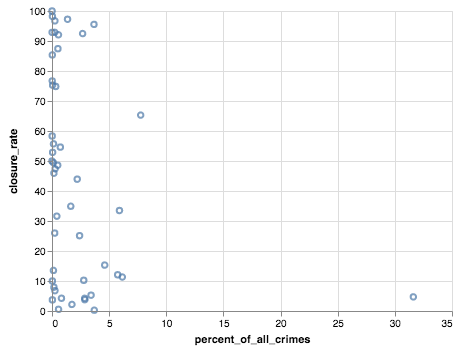

In [28]:
alt.Chart(
    status_by_crime
).mark_point(
).encode(
    x = 'percent_of_all_crimes',
    y = 'closure_rate'
)

This type of chart is known as a scatterplot. It is used to check for a relationship or correlation between two different variables - in this case `percent_of_all_crimes` and `closure_rate`. There is very little clustering of the data points here, indicating that there is no real relationship. So there is not a lot to glean from this chart, other than the fact that the most common crime has a very low closure rate. So what crime is that?

In [29]:
status_by_crime.sort_values('percent_of_all_crimes', ascending = False).head(1)

,Incident Category,Closed,Open,Total,closure_rate,percent_of_all_crimes
19,Larceny Theft,2286.0,46413.0,48699,4.694142,31.61821


So larcenies are the most common crime. The low closure rate at the time the report was filed is not surprising either. A lot of times an officer doesn't even respond to these types of calls. Instead victims fill out police reports and submit them online or by mail. But it warrants looking further into larcenies.

## Diving deeper into larcenies

Let's start by isolating those records related to larceny and then look at the subcategories for larceny.

In [30]:
larcenies = incidents.loc[incidents['Incident Category'] == 'Larceny Theft',:]
larcenies.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point,incident_timestamp,report_timestamp,case_status
2,2018/10/14 02:54:00 PM,2018-10-14,14:54,2018,Sunday,2018/10/24 01:10:00 PM,72980906303,729809,180807520,182971760.0,...,23104000.0,Taraval,Lakeshore,7.0,37.720450,-122.483015,"(37.7204499957522, -122.48301534194144)",2018-10-14 14:54:00,2018-10-24 13:10:00,Open
12,2018/10/25 10:40:00 AM,2018-10-25,10:40,2018,Thursday,2018/10/25 01:32:00 PM,73019506244,730195,180810078,182982046.0,...,33719000.0,Taraval,Lakeshore,7.0,37.726950,-122.476039,"(37.72694991292525, -122.47603947349434)",2018-10-25 10:40:00,2018-10-25 13:32:00,Open
13,2018/10/25 07:30:00 AM,2018-10-25,07:30,2018,Thursday,2018/10/25 07:36:00 AM,73019906154,730199,180809350,182980609.0,...,20356000.0,Ingleside,Visitacion Valley,10.0,37.712547,-122.407348,"(37.712547388545694, -122.40734778224339)",2018-10-25 07:30:00,2018-10-25 07:36:00,Open
15,2018/10/24 12:30:00 PM,2018-10-24,12:30,2018,Wednesday,2018/10/25 05:06:00 AM,73021006374,730210,180809714,182980359.0,...,23827000.0,Southern,South of Market,6.0,37.778327,-122.396531,"(37.7783268304671, -122.39653063923612)",2018-10-24 12:30:00,2018-10-25 05:06:00,Open
16,2018/10/25 01:39:00 PM,2018-10-25,13:39,2018,Thursday,2018/10/25 04:56:00 PM,73024006242,730240,180810705,182982924.0,...,23606000.0,Southern,Financial District/South Beach,6.0,37.788838,-122.389429,"(37.78883777870189, -122.38942894299095)",2018-10-25 13:39:00,2018-10-25 16:56:00,Open


In [31]:
larcenies[['Incident Subcategory', 'Row ID']].groupby('Incident Subcategory', as_index = False).count()

,Incident Subcategory,Row ID
0,Larceny - Auto Parts,75
1,Larceny - From Vehicle,28409
2,Larceny Theft - Bicycle,618
3,Larceny Theft - From Building,3024
4,Larceny Theft - Other,11641
5,Larceny Theft - Pickpocket,794
6,Larceny Theft - Purse Snatch,30
7,Larceny Theft - Shoplifting,2693
8,Theft From Vehicle,1415


Wait a minute. There are two subcategories that appear to be the same - `Larceny - From Vehicle` and `Theft From Vehicle`. Let's combine those two and re-run this portion of the analysis.

In [32]:
larcenies['Incident Subcategory'].replace({'Theft From Vehicle' : 'Larceny - From Vehicle'}, inplace = True)

larcenies[['Incident Subcategory', 'Row ID']].groupby('Incident Subcategory', as_index = False).count()

/Users/tumgoren/.local/share/virtualenvs/sfgov-1jv1HqtK/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Incident Subcategory,Row ID
0,Larceny - Auto Parts,75
1,Larceny - From Vehicle,29824
2,Larceny Theft - Bicycle,618
3,Larceny Theft - From Building,3024
4,Larceny Theft - Other,11641
5,Larceny Theft - Pickpocket,794
6,Larceny Theft - Purse Snatch,30
7,Larceny Theft - Shoplifting,2693


So theft from vehicles is the most common type of larceny. Let's isolate that and dig in further.

In [33]:
thefts_from_car = larcenies.loc[larcenies['Incident Subcategory'] == 'Larceny - From Vehicle', :]
thefts_from_car['Row ID'].count()

29824

How often are cases closed at the time of when the report was filed?

In [34]:
thefts_status = thefts_from_car['case_status'].value_counts()
thefts_status

Open      29234
Closed      590
Name: case_status, dtype: int64

In [35]:
(thefts_status['Closed'] / (thefts_status['Open'] + thefts_status['Closed'])) * 100.0

1.9782725321888412

Less than 2 percent of the time. That's not very high. Let's ask some other questions.

### Where are these types of thefts most common?

In [37]:
by_neighborhood = thefts_from_car[['Analysis Neighborhood', 'Row ID']].groupby(
    'Analysis Neighborhood', 
    as_index = False
).count()

by_neighborhood.rename(columns = {'Row ID' : 'Thefts'}, inplace = True)

#by_neighborhood = by_district.sort_values('Thefts', ascending = False)
by_neighborhood = by_neighborhood.sort_values('Thefts', ascending = False)

by_neighborhood.head(10)

,Analysis Neighborhood,Thefts
18,Mission,2581
5,Financial District/South Beach,2103
22,North Beach,1971
33,South of Market,1825
31,Russian Hill,1631
40,Western Addition,1301
9,Hayes Valley,1292
35,Tenderloin,1252
16,Marina,901
25,Outer Richmond,825


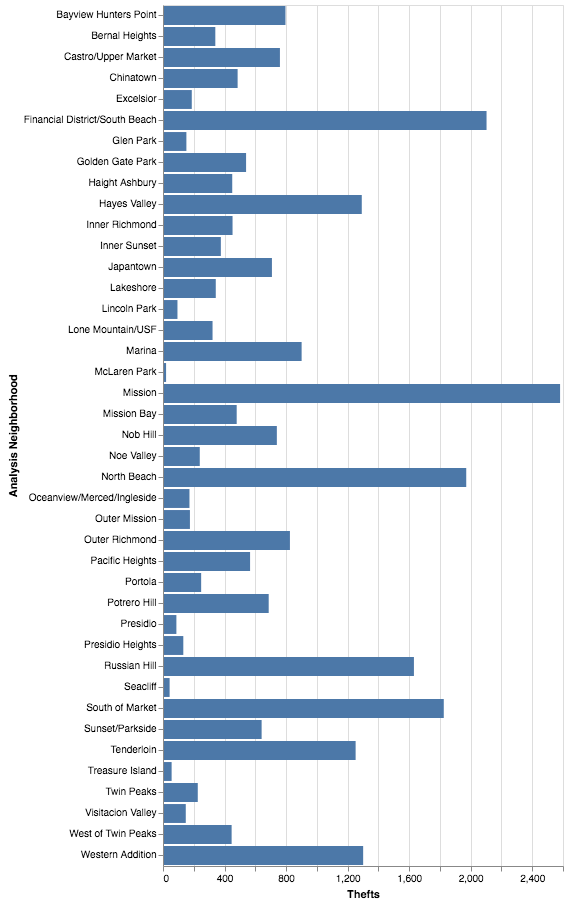

In [38]:
alt.Chart(by_neighborhood).mark_bar().encode(x = 'Thefts', y = 'Analysis Neighborhood')

### What time of day are thefts from cars most common?

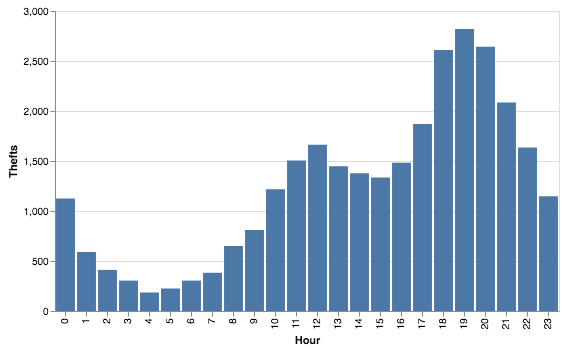

In [39]:
by_hour = thefts_from_car[['incident_timestamp', 'Row ID']].groupby(thefts_from_car['incident_timestamp'].dt.hour.rename('Hour')).agg({'Row ID': 'count'})
by_hour = pd.DataFrame(by_hour.to_records())
by_hour.rename(columns = {'Row ID' : 'Thefts'}, inplace = True)

alt.Chart(by_hour).mark_bar().encode(y = 'Thefts', x = 'Hour:O')

In [40]:
(thefts_from_car['report_timestamp'] - thefts_from_car['incident_timestamp']).median()

Timedelta('0 days 09:23:00')